In [1]:
from SOM import *
from PZ import *
from pipeline_tools import *

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
pz = load_PZ('../outputs/basic/PZ_pipeline/')

wide_SOM = pz.wide_SOM
deep_SOM = pz.deep_SOM

## Catalog Checking

### Wide Sample

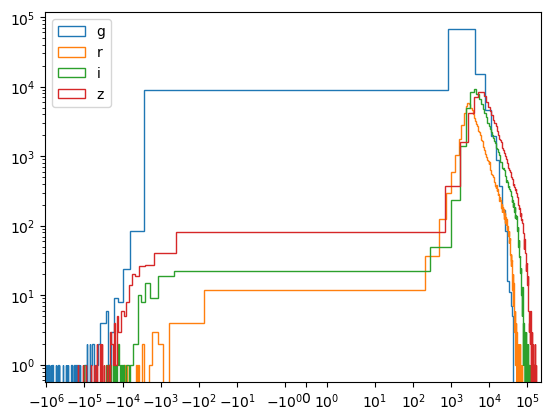

In [3]:
wide_som_sample = wide_SOM.validate_sample ; bands = ['g','r','i','z']
# range=(-1000000,-10), 
[plt.hist(wide_som_sample['Mf_%s'%b], 300, histtype='step', label=b) for b in bands]
plt.legend()
plt.yscale('log') ; plt.xscale('symlog')
#plt.xlim(-1000000,0)
plt.show()

### Deep Sample

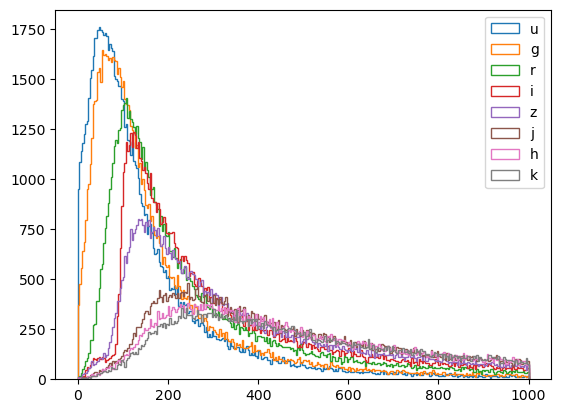

In [4]:
deep_som_sample = deep_SOM.validate_sample ; bands = list('ugrizjhk')
# 
[plt.hist(deep_som_sample['Mf_%s'%b], 300, range=(0, 1000), histtype='step', label=b) for b in bands]
plt.legend()
#plt.yscale('log') #; plt.xscale('symlog')
#plt.xlim(-1000000,0)
plt.show()

['ra', 'dec', 'id', 'NUNIQUE', 'e1', 'e2', 'Mf', 'Mr', 'SN_', 'Q0', 'Q1', 'P', 'R00', 'R01', 'R11', 'tomo_bin', 'psf_f', 'psf_r', 'psf_1', 'psf_2', 'Mf_g', 'Mf_r', 'Mf_i', 'Mf_z', 'TIER_NUM', 'M1', 'M2', 'cov_Mf_g', 'cov_Mf_r', 'cov_Mf_i', 'cov_Mf_z', 'DNF_Z', 'mag_auto_g', 'mag_auto_r', 'mag_auto_i', 'mag_auto_z', 'DNF_Z_MC', 'nz_R_weight', 'CA']


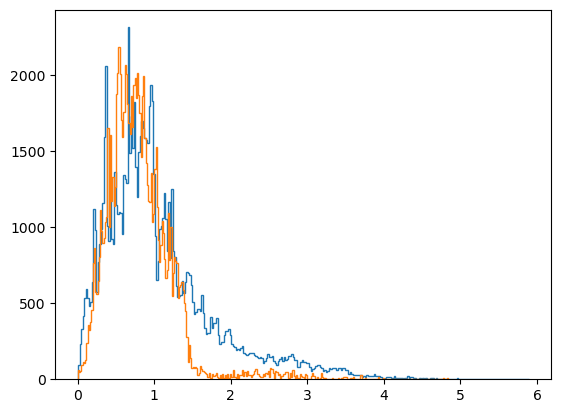

In [5]:
plt.hist(deep_som_sample['COSMOS_PHOTZ'], 300, histtype='step')
print(wide_som_sample.colnames)
plt.hist(wide_som_sample['DNF_Z_MC'], 300, histtype='step')
plt.show()

# SOM Validation

## Wide SOM

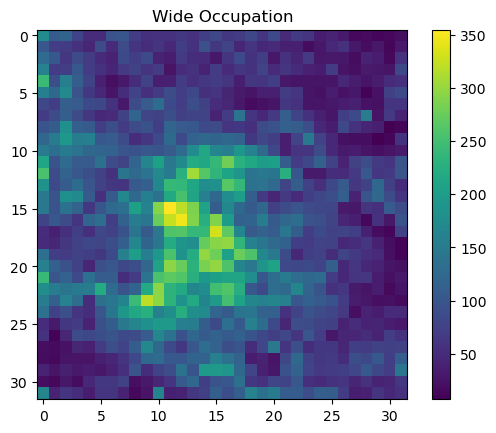

In [6]:
occ = wide_SOM.get('occupation')

plt.imshow(occ)
plt.colorbar()
plt.title("Wide Occupation")

plt.show()

In [7]:
bands = ['g','r','i','z']
means = [wide_SOM.get('mean','Mf_%s'%b) for b in bands]
stds = [wide_SOM.get('std','Mf_%s'%b) for b in bands]

means_mag = [flux_to_mag(m) for m in means]
stds_mag = [flux_to_mag(s) for s in stds]

/global/homes/d/dncross/SOMs/SOM-photoz-BFD/src/pipeline_tools.py:8: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(f) + const


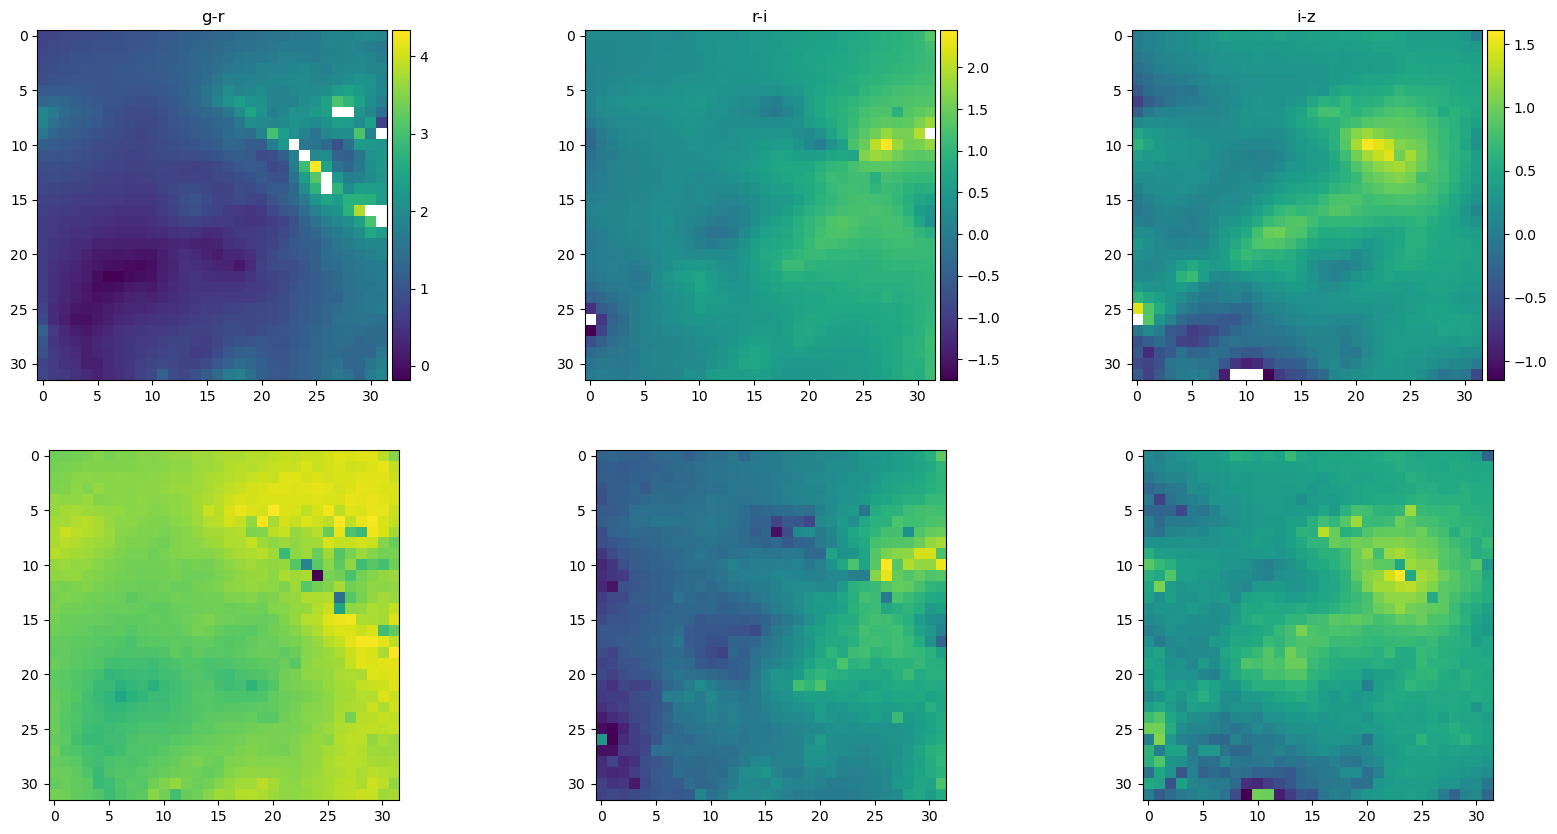

In [8]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
for i, (b1, b2) in enumerate(zip(bands, bands[1:])):
    im1=ax[0,i].imshow(means_mag[i]-means_mag[i+1])
    ax[1,i].imshow(stds_mag[i]-stds_mag[i+1])
    
    divider = make_axes_locatable(ax[0,i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    
    ax[0,i].set_title('%s-%s'%(b1,b2))
    
plt.show()

## Deep SOM

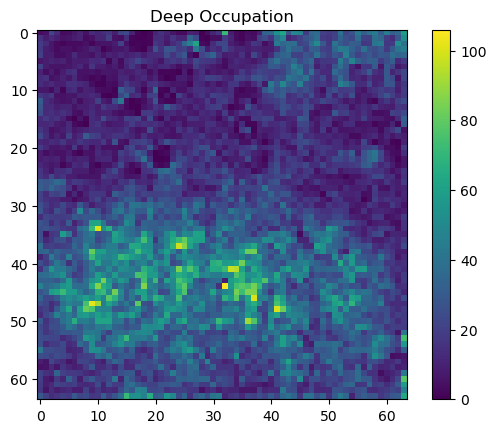

In [9]:
occ = deep_SOM.get('occupation')

plt.imshow(occ)
plt.colorbar()
plt.title("Deep Occupation")

plt.show()

In [10]:
bands = ['u','g','r','i','z','j','h','k']
means = [deep_SOM.get('mean','Mf_%s'%b) for b in bands]
stds = [deep_SOM.get('std','Mf_%s'%b) for b in bands]

means_mag = [flux_to_mag(m) for m in means]
stds_mag = [flux_to_mag(s) for s in stds]

/global/homes/d/dncross/SOMs/SOM-photoz-BFD/src/SOM.py:187: RuntimeWarning: Mean of empty slice
  return np.nanmean(col[(col<np.inf)&(col>-0.9e10)])
/global/homes/d/dncross/SOMs/SOM-photoz-BFD/src/pipeline_tools.py:8: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(f) + const


/tmp/ipykernel_194871/1589255043.py:3: RuntimeWarning: invalid value encountered in subtract
  im1=ax[0,i].imshow(means_mag[i]-means_mag[i+1])
/tmp/ipykernel_194871/1589255043.py:4: RuntimeWarning: invalid value encountered in subtract
  ax[1,i].imshow(stds_mag[i]-stds_mag[i+1])


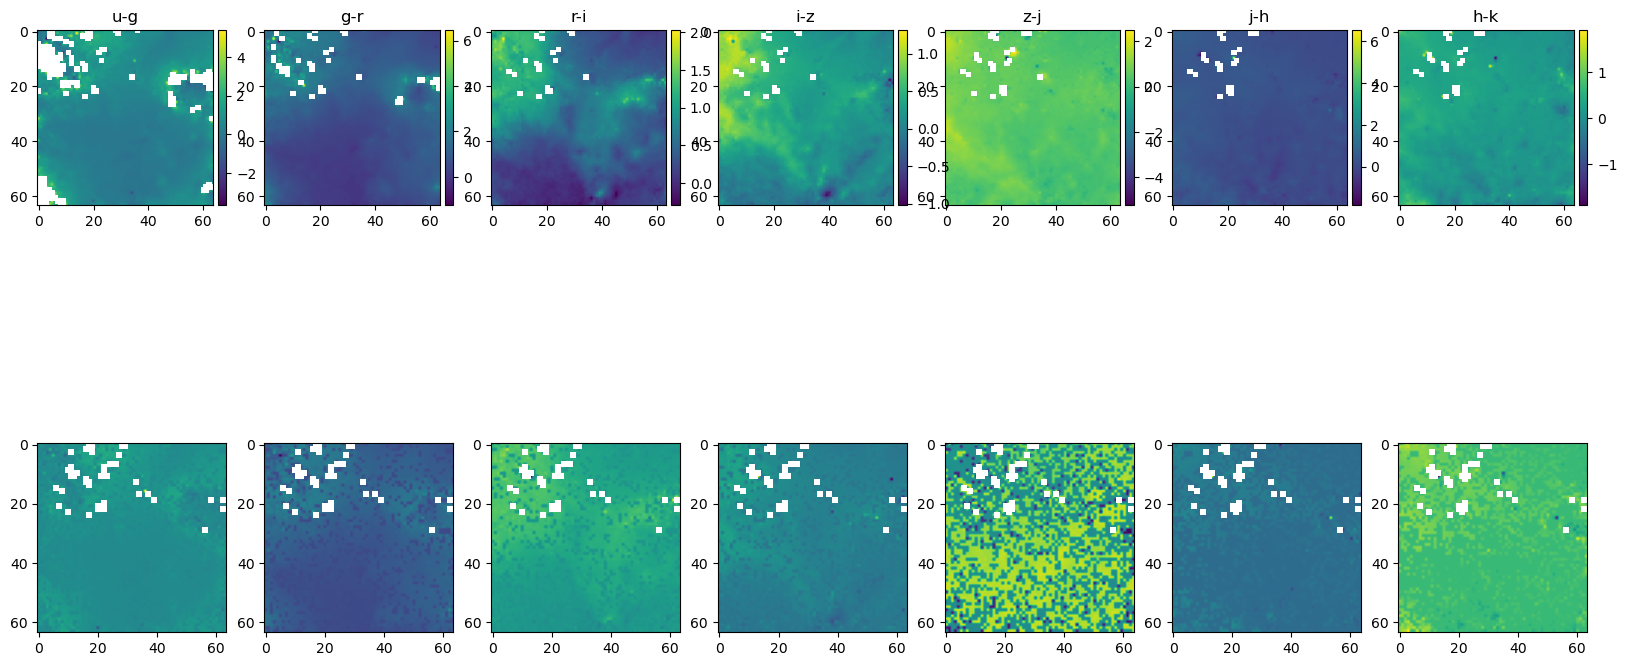

In [11]:
fig, ax = plt.subplots(2,len(bands)-1, figsize=(20,10))
for i, (b1, b2) in enumerate(zip(bands, bands[1:])):
    im1=ax[0,i].imshow(means_mag[i]-means_mag[i+1])
    ax[1,i].imshow(stds_mag[i]-stds_mag[i+1])
    
    divider = make_axes_locatable(ax[0,i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    
    ax[0,i].set_title('%s-%s'%(b1,b2))
    
plt.show()

# Tomographic Binning

In [12]:
five_percent = pz.make_bins(4, compost_bin=0.05)

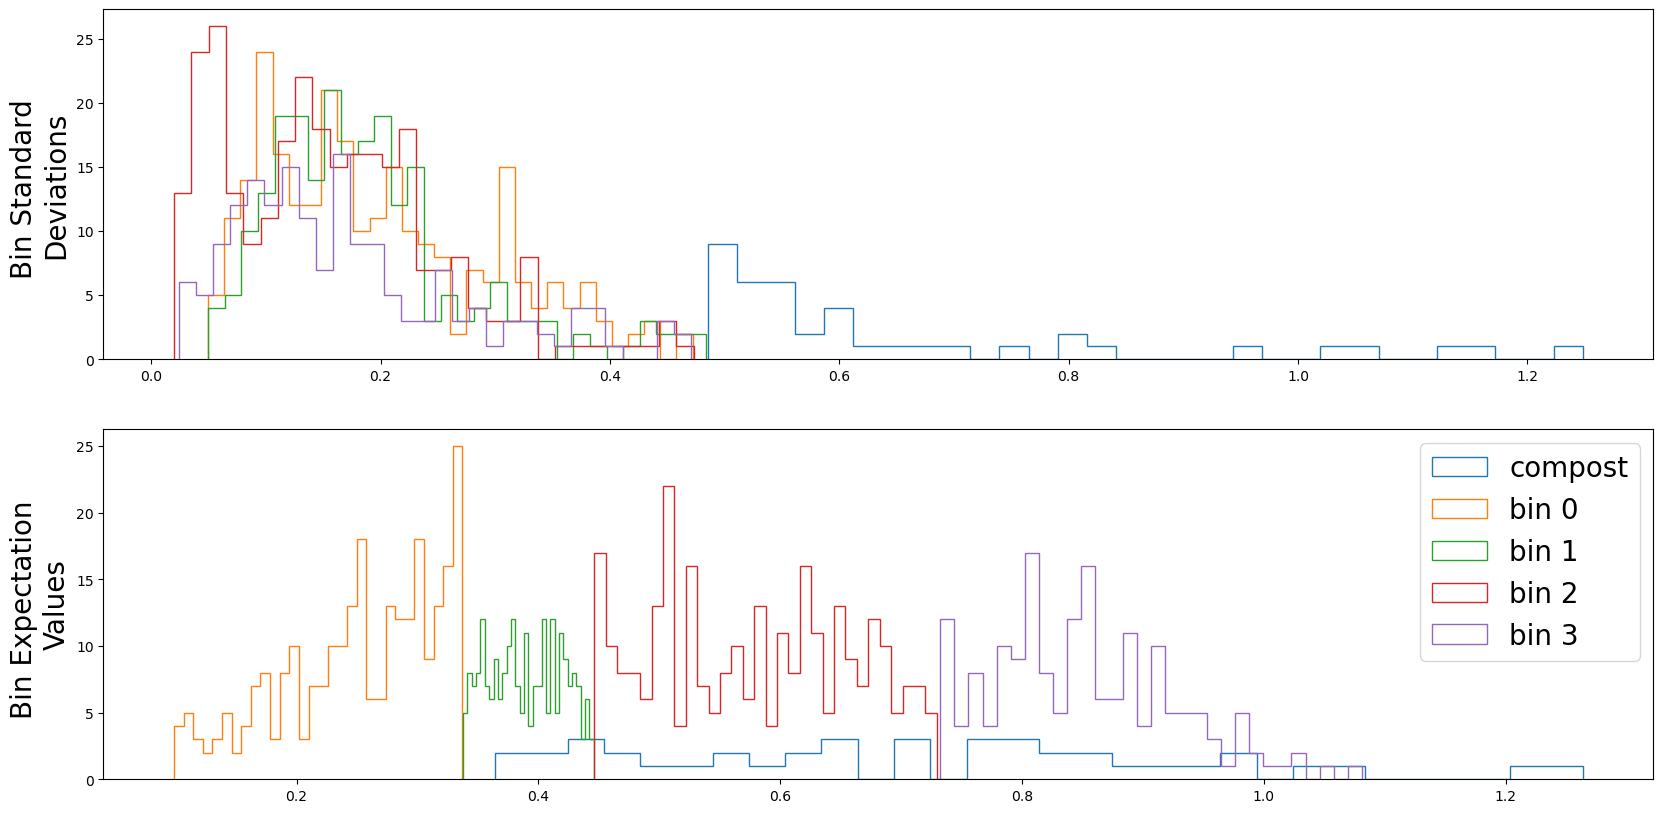

In [13]:
compost_std = np.array([D(five_percent.z, five_percent.pzchat[wc]) for wc in five_percent.compost_WCs])
bin_stds = [np.array([D(five_percent.z, pzi) for pzi in five_percent.pzchat[WCs]] )
                     for WCs in five_percent.binned_WCs]

compost_mm = [E(five_percent.z, pzi) for pzi in five_percent.pzchat[five_percent.compost_WCs]]
bin_mms = [[E(five_percent.z, pzi) for pzi in five_percent.pzchat[WCs]] for WCs in five_percent.binned_WCs]

fig, axs = plt.subplots(2, figsize=(20,10))
for a,comp,bins in zip(axs, [compost_std, compost_mm], [bin_stds, bin_mms]):
    a.hist(comp, 30, label='compost', histtype='step')
    [a.hist(b, 30, label="bin %i"%i, histtype='step') for i,b in enumerate(bins)]

axs[0].set_ylabel("Bin Standard \nDeviations", fontsize=20)
axs[1].set_ylabel("Bin Expectation \nValues", fontsize=20)
plt.legend(fontsize=20)
plt.show()

Text(0.5, 0, 'Redshift')

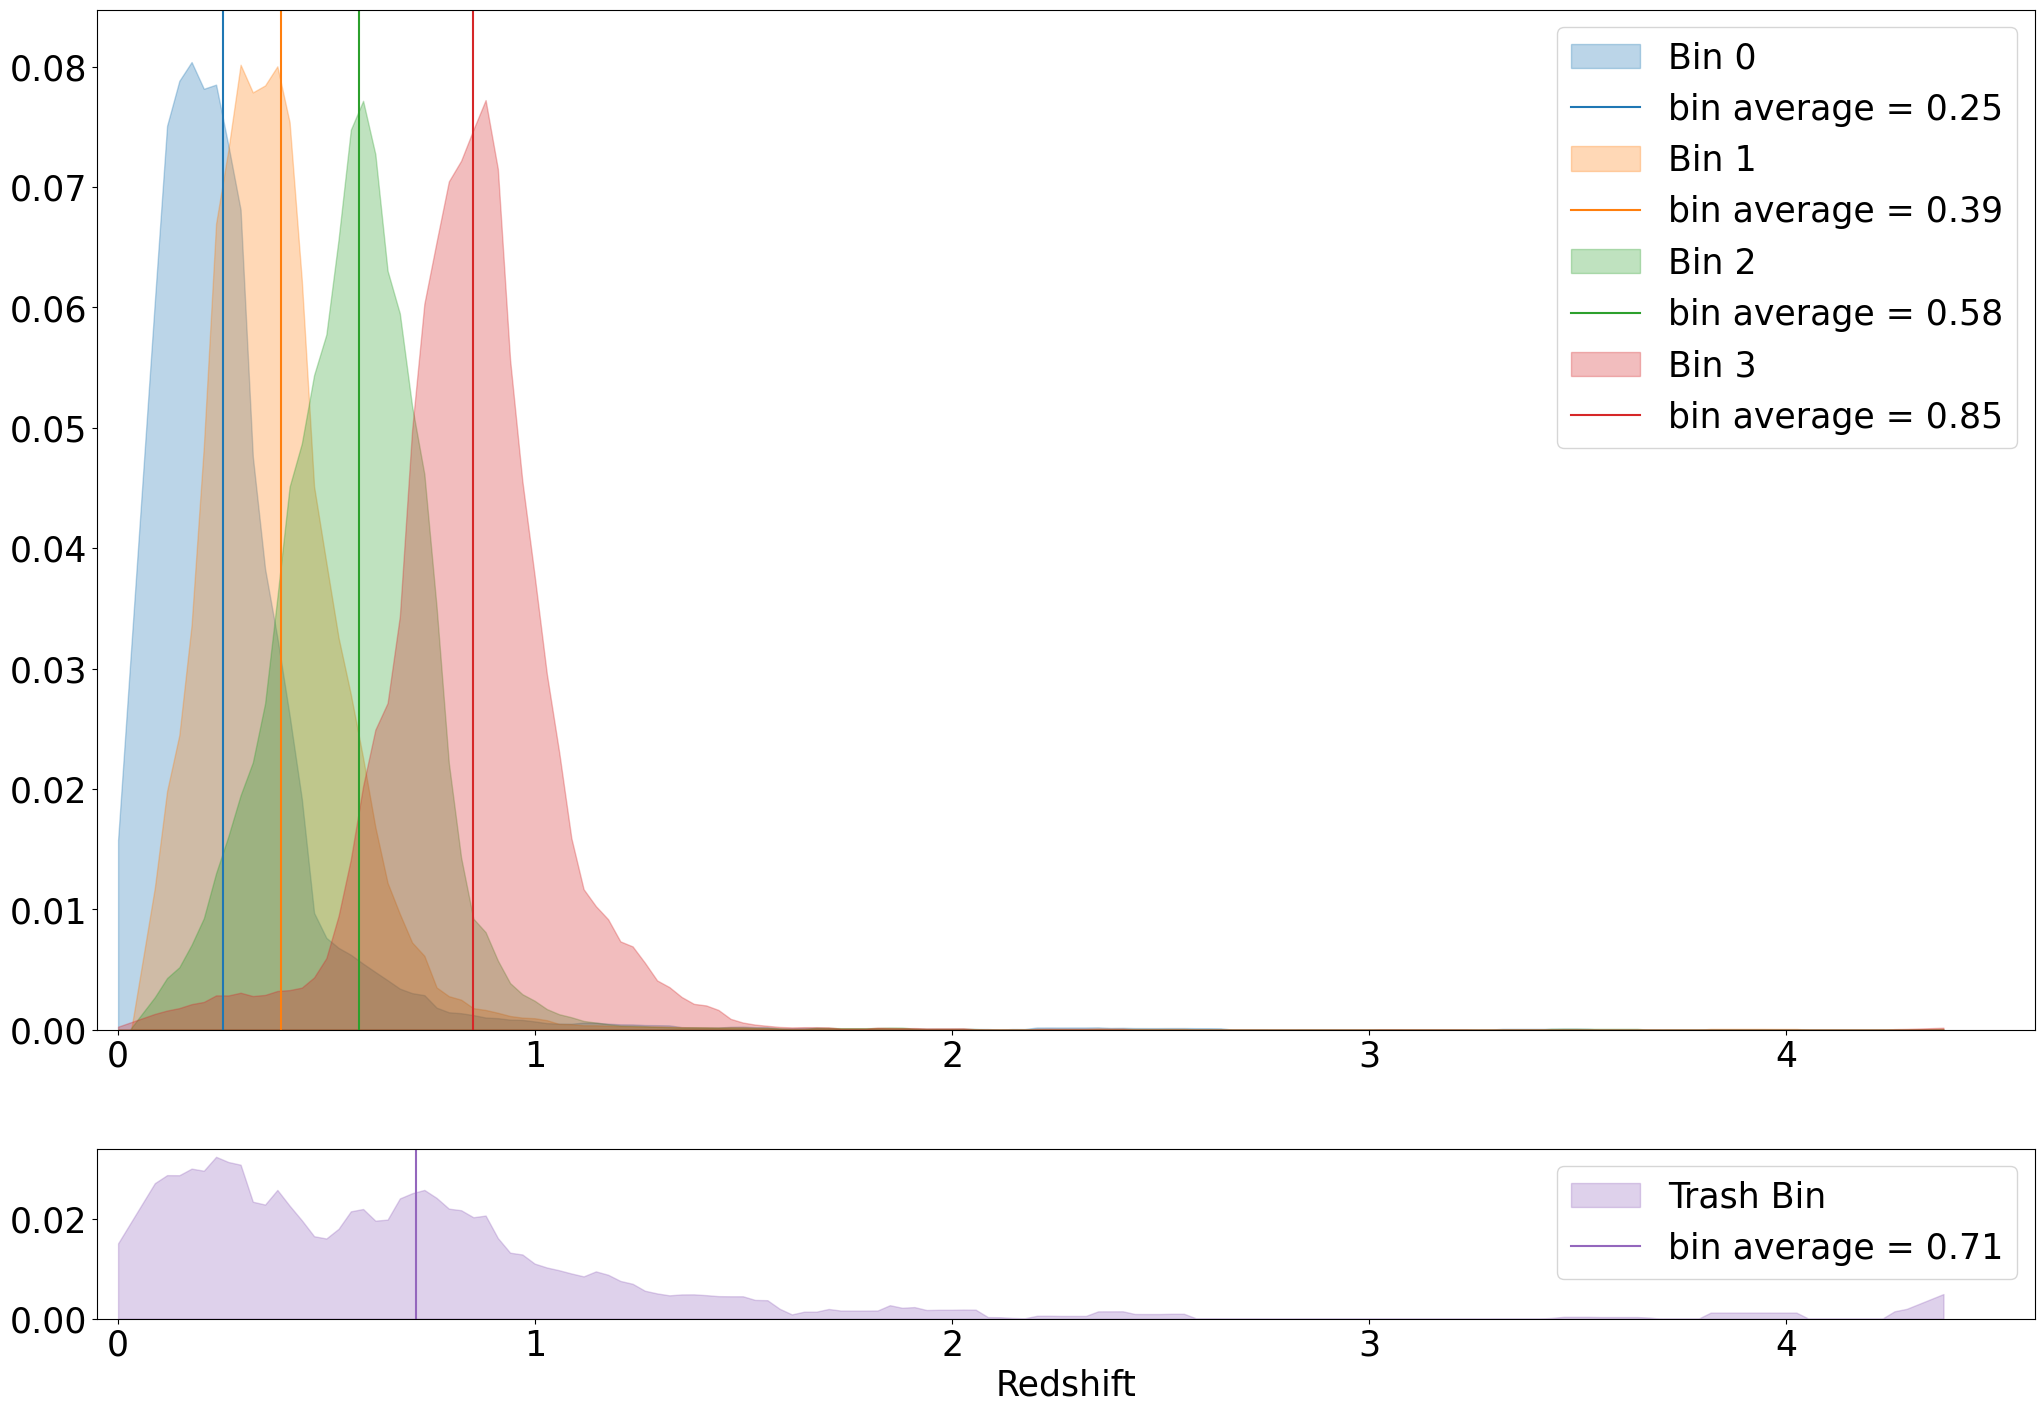

In [14]:
distributions = five_percent.calculate_Nz()
z = five_percent.z

colors = [plt.cm.tab20(i*2) for i in range(5)]
fig, ax = plt.subplots(2, figsize=(25,17), height_ratios=[6,1])
for i in distributions:
    if i == -1: continue
    nz = distributions[i]
    #ax[0].plot(z,nz, color=colors[i])
    ax[0].fill_between([0]+z, [0]+savgol_filter(nz, 8, 1), alpha=0.3, color=colors[i], label="Bin %i"%i)

    av = E(z,nz) 
    ax[0].axvline(av, color=colors[i], label='bin average = %.02f'%av)


nz = distributions[-1]
#ax[1].plot(z, nz, color=colors[-1],)
ax[1].fill_between([0]+z, [0]+savgol_filter(nz, 8,1), alpha=0.3, color=colors[-1], label='Trash Bin')
av = E(z,nz) 
ax[1].axvline(av, color=colors[-1], label='bin average = %.02f'%av)

[a.set_ylim(bottom=0) for a in ax]
[a.set_xlim(left=-0.05) for a in ax]

ax[0].legend(fontsize=25)
ax[1].legend(fontsize=25)
ax[0].tick_params(axis='both', which='major', labelsize=25)
ax[1].tick_params(axis='both', which='major', labelsize=25)

ax[1].set_xlabel('Redshift', fontsize=25)
